In [45]:
from dotenv import load_dotenv
# from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain_community.document_loaders import WebBaseLoader
# from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
# import faiss
from langgraph.prebuilt import ToolExecutor
from langchain.tools.retriever import create_retriever_tool
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
# from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolInvocation
from langchain_core.output_parsers import StrOutputParser

from langgraph.graph import END, StateGraph
from langchain_teddynote.graphs import visualize_graph


import pprint
from langchain_core.messages import HumanMessage


load_dotenv()

True

In [ ]:
# urls = [
#     "https://lilianweng.github.io/posts/2023-06-23-agent/",
#     "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
#     "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
# ]

# docs = [WebBaseLoader(url).load() for url in urls]
# docs_list = [item for sublist in docs for item in sublist]

# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=100, chunk_overlap=50
# )
# doc_splits = text_splitter.split_documents(docs_list)

# # 벡터 데이터베이스에 문서 추가
# vectorstore = Chroma.from_documents(
#     documents=doc_splits,
#     collection_name="rag-chroma",
#     embedding=OpenAIEmbeddings(),
# )
# retriever = vectorstore.as_retriever()

In [31]:
index_file = "faiss_index_jg"

# FAISS 벡터 스토어 불러오기
vector_store = FAISS.load_local(
    index_file, 
    OpenAIEmbeddings(),
    allow_dangerous_deserialization=True
)

In [35]:
retriever = vector_store.as_retriever()

In [37]:


# 릴리안 웡의 블로그 게시물에 대한 정보를 검색하고 반환하는 도구를 생성합니다.
tool = create_retriever_tool(
    retriever,
    "Tourist_Helper_Retriever",
    "SIt is a retriever that recommends tourist places including cafes, restaurants, and bars in Jongno-gu, Jung-gu, Yongsan-gu, and Gangnam-gu in Seoul",
)

tools = [tool]


# 도구들을 실행할 ToolExecutor 객체를 생성합니다.
tool_executor = ToolExecutor(tools)

/var/folders/_v/g1qmsq595kq_fg_zv8n2022h0000gn/T/ipykernel_66897/3663877542.py:12: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


In [39]:
class AgentState(TypedDict):
    # AgentState 클래스는 메시지 시퀀스를 포함하는 타입 딕셔너리입니다.
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [48]:
# Edges


def should_retrieve(state):
    """
    에이전트가 더 많은 정보를 검색해야 하는지 또는 프로세스를 종료해야 하는지 결정합니다.

    이 함수는 상태의 마지막 메시지에서 함수 호출을 확인합니다. 함수 호출이 있으면 정보 검색 프로세스를 계속합니다. 그렇지 않으면 프로세스를 종료합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        str: 검색 프로세스를 "계속"하거나 "종료"하는 결정
    """

    print("---DECIDE TO RETRIEVE---")
    messages = state["messages"]
    last_message = messages[-1]

    # 함수 호출이 없으면 종료합니다.
    if "function_call" not in last_message.additional_kwargs:
        print("---DECISION: DO NOT RETRIEVE / DONE---")
        return "end"
    # 그렇지 않으면 함수 호출이 있으므로 계속합니다.
    else:
        print("---DECISION: RETRIEVE---")
        return "continue"


def grade_documents(state):
    """
    검색된 문서가 질문과 관련이 있는지 여부를 결정합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        str: 문서가 관련이 있는지 여부에 대한 결정
    """

    print("---CHECK RELEVANCE---")

    # 데이터 모델
    class grade(BaseModel):
        """관련성 검사를 위한 이진 점수."""

        binary_score: str = Field(description="'yes' 또는 'no'의 관련성 점수")

    # LLM
    model = ChatOpenAI(
        temperature=0, model="gpt-4o", streaming=True)

    # 도구
    grade_tool_oai = convert_to_openai_tool(grade)

    # 도구와 강제 호출을 사용한 LLM
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(grade_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "grade"}},
    )

    # 파서
    parser_tool = PydanticToolsParser(tools=[grade])

    # 프롬프트
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # 체인
    chain = prompt | llm_with_tool | parser_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    score = chain.invoke({"question": question, "context": docs})

    grade = score[0].binary_score

    if grade == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "yes"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(grade)
        return "no"


# Nodes


def agent(state):
    """
    현재 상태를 기반으로 에이전트 모델을 호출하여 응답을 생성합니다. 질문에 따라 검색 도구를 사용하여 검색을 결정하거나 단순히 종료합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        dict: 메시지에 에이전트 응답이 추가된 업데이트된 상태
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True,
                       model="gpt-4o")
    functions = [format_tool_to_openai_function(t) for t in tools]
    model = model.bind_functions(functions)
    response = model.invoke(messages)
    # 이것은 기존 목록에 추가될 것이므로 리스트를 반환합니다.
    return {"messages": [response]}


def retrieve(state):
    """
    도구를 사용하여 검색을 실행합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        dict: 검색된 문서가 추가된 업데이트된 상태
    """
    print("---EXECUTE RETRIEVAL---")
    messages = state["messages"]
    # 계속 조건을 기반으로 마지막 메시지가 함수 호출을 포함하고 있음을 알 수 있습니다.
    last_message = messages[-1]
    # 함수 호출에서 ToolInvocation을 구성합니다.
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        ),
    )
    # 도구 실행자를 호출하고 응답을 받습니다.
    response = tool_executor.invoke(action)
    function_message = FunctionMessage(content=str(response), name=action.tool)

    # 이것은 기존 목록에 추가될 것이므로 리스트를 반환합니다.
    return {"messages": [function_message]}


def rewrite(state):
    """
    질문을 변형하여 더 나은 질문을 생성합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        dict: 재구성된 질문이 추가된 업데이트된 상태
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # 평가자
    model = ChatOpenAI(
        temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    답변 생성

    Args:
        state (messages): 현재 상태

    Returns:
         dict: 재구성된 질문이 추가된 업데이트된 상태
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # 프롬프트
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o",
                     temperature=0, streaming=True)

    # 후처리
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # 체인
    rag_chain = prompt | llm | StrOutputParser()

    # 실행
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [43]:
# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(AgentState)

# 순환할 노드들을 정의합니다.
workflow.add_node("agent", agent)  # 에이전트 노드를 추가합니다.
workflow.add_node("retrieve", retrieve)  # 정보 검색 노드를 추가합니다.
workflow.add_node("rewrite", rewrite)  # 정보 재작성 노드를 추가합니다.
workflow.add_node("generate", generate)  # 정보 생성 노드를 추가합니다.

In [44]:
# 에이전트 노드 호출하여 검색 여부 결정
workflow.set_entry_point("agent")

# 검색 여부 결정
workflow.add_conditional_edges(
    "agent",
    # 에이전트 결정 평가
    should_retrieve,
    {
        # 도구 노드 호출
        "continue": "retrieve",
        "end": END,
    },
)

# `action` 노드 호출 후 진행될 경로
workflow.add_conditional_edges(
    "retrieve",
    # 에이전트 결정 평가
    grade_documents,
    {
        "yes": "generate",
        "no": "rewrite",
    },
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# 컴파일
app = workflow.compile()

In [49]:
# HumanMessage 객체를 사용하여 질문 메시지를 정의합니다.
inputs = {
    "messages": [
        HumanMessage(
            content="중구에있는 카페를 5개 추천해줘 그리고 그 이유에 대해서도 알려줘"
        )
    ]
}
# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
for output in app.stream(inputs):
    # 출력된 결과에서 키와 값을 순회합니다.
    for key, value in output.items():
        # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        # 출력 값을 예쁘게 출력합니다.
        pprint.pprint(value, indent=2, width=80, depth=None)
    # 각 출력 사이에 구분선을 추가합니다.
    pprint.pprint("\n---\n")

---CALL AGENT---
---DECIDE TO RETRIEVE---
---DECISION: RETRIEVE---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"중구 카페"}', 'name': 'Tourist_Helper_Retriever'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4-0125-preview'}, id='run-cf1fbeca-0bfe-4c18-9aa7-e3c25da0cda7-0')]}
'\n---\n'
---EXECUTE RETRIEVAL---


/var/folders/_v/g1qmsq595kq_fg_zv8n2022h0000gn/T/ipykernel_66897/713059591.py:138: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ FunctionMessage(content="store_name: 카페051 중구저동점\ncategory: ['카페']\nrating: 정보없음\naddress: 서울 중구 수표로 30-2 1층\nphone_num: 0507-1352-0781\n\nstore_name: 카페무\ncategory: ['카페', '디저트']\nrating: 정보없음\naddress: 서울 중구 을지로20길 20\n\nstore_name: 정카페\ncategory: ['카페']\nrating: 정보없음\naddress: 서울 중구 청구로 61-1\n\nstore_name: 카페인중독 왕십리점\ncategory: ['와플']\nrating: 정보없음\naddress: 서울 성동구 마장로 137 214동 126호 카페인중독 왕십리점\nphone_num: 02-2298-0816", additional_kwargs={}, response_metadata={}, name='Tourist_Helper_Retriever')]}
'\n---\n'
---GENERATE---


/opt/homebrew/Caskroom/miniconda/base/envs/langraph/lib/python3.11/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ "I'm sorry, but based on the provided context, I can only "
                'recommend three cafes in 중구: 카페051 중구저동점, 카페무, and 정카페. The '
                'reasons for recommendation cannot be provided as the ratings '
                'and specific features of these cafes are not mentioned in the '
                'context.']}
'\n---\n'


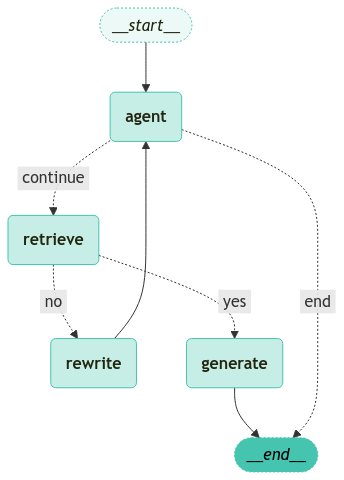

In [ ]:

visualize_graph(app)